# Titanic Data Preparation

* Análise do problema de negócios;
* Compreensão sobre os dados (extração dos dados, limpeza);
* Preparação (análise exploratória).

## Business Problem/Understanding

### From the data given try and infer for each passenger if it survived.

First of all, some columns provide no inference power
like `Name`, the `Ticket` number and `PassengerId`,
so the best approach is to simply drop them.

A column that is hard to deal with is the `Cabin` number,
as it's missing a lot of values, and even if there's
some correlation between the cabin number as a position
inside the Titanic, it's not clear to me a conversion
that would make possible to a model to make use of this
implicit information.

The `Embarked` and `Sex` attributes would benefit from
being converted into an one-hot-encoding format as
they are categorical.

There's also redundancy with the attributes `Fare`
and `Embarked` as they simply encode the class and from
which port the passenger boarded the Titanic.
Further processing can try and classify if a passanger
paid more or less than the average price for that specific
port and class (maybe indicating the passenger's
buying power). But even if that was made the `Fare`
column is just combined information from the `Embarked`
and `Pclass` attributes.

The `Age` column is missing a single value so it seems appropriate
to drop that single row it as it may not warrant a need to imputate
a value.


## Data Preparation/Cleaning

In [1]:
import dask.dataframe as dd
import numpy as np

data_size = "full"
data_path = f"./data/titanic/{data_size}"

In [2]:
df_train = dd.read_csv(f"{data_path}/train.csv")

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.compute().describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df_train = df_train.drop(columns=['PassengerId', 'Name', 'Ticket'])
df_train = df_train.drop(columns=['Cabin'])
df_train = df_train.dropna(subset=['Age'])

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [5]:
df_train_sex = dd.get_dummies(df_train['Sex'].compute(), prefix='SEX')
df_train_embarked = dd.get_dummies(df_train['Embarked'].compute(), prefix='EMBARKED')

df_train = df_train.drop(columns=['Sex', 'Embarked'])
df_train = dd.concat([df_train.compute(), df_train_sex, df_train_embarked], axis=1)

df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,SEX_female,SEX_male,EMBARKED_C,EMBARKED_Q,EMBARKED_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


## Extra - Classification Attempt

In [6]:
X_train = df_train.drop(columns=['Survived']).compute()
y_train = df_train['Survived'].compute()

y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [7]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

clf.score(X_train, y_train)

0.7801120448179272

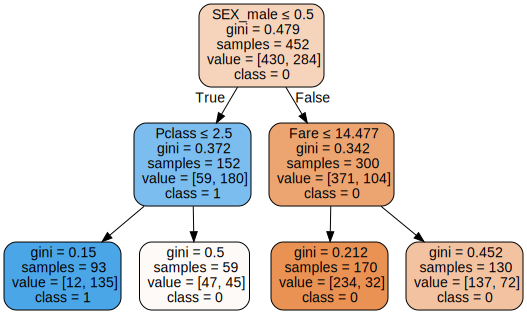

In [8]:
import graphviz

from sklearn.tree import export_graphviz
dot_data= export_graphviz(clf.estimators_[0], out_file = None,
                    feature_names = X_train.columns,
                      class_names = ['0', '1'],
                      filled = True, rounded = True,
                      special_characters = True, impurity = True)
                      
graph = graphviz.Source(dot_data, format='png')
graph